## Introdução
O EP3 tem dois objetivos principais: 

Parte 3.1- Segmentação do objeto de interesse: O objetivo desta etapa é segmentar o  objeto do fundo, produzindo uma imagem binária: 0 para o fundo e 1 para o objeto. Dois tipos de segmentação serão usados: manual, para geração do ground-truth, e automática usando algum algoritmo de sua escolha. 

Parte 3.2- Classificação do objeto de interesse. Ou seja, aplicar PCA e SVM para classificar os objetos entre as classes definidas.

Nas duas etapas, a acurácia das soluções serão calculadas.

## Header 3.1

Parte 3.1- Segmentação do objeto de interesse: O objetivo desta etapa é segmentar o  objeto do fundo, produzindo uma imagem binária: 0 para o fundo e 1 para o objeto. Dois tipos de segmentação serão usados: manual, para geração do ground-truth, e automática usando algum algoritmo de sua escolha. 

O ground-truth deve ser gerado para pelo menos 15% das amostras de cada classe. Ferramentas possíveis para geração do ground-truth:

a) utilizar um software de edição de imagens como o GIMP, Paint, etc.

b) programas de geração de ground-truth  (eg. programa do Eduardo, supervise , labelstudio, etc.)


--------------------
Autores: Luan Carlos da Silva Casagrande
Paulo Henrique da Silveira
Yoshio Mori

## Constantes

## Segmentação Automática

Bibliotécas necessárias

In [1]:
import pathlib

from skimage import io
from skimage import morphology
from skimage import filters
from skimage import feature
from skimage import segmentation
from matplotlib import pyplot
import numpy
import math

Iremos trabalhar encima da seguinte imagem

In [2]:
image_path = pathlib.Path(r"originalGrayDataset\TENIS\DIA\DENTRO\GRANITO\20210424_114639.jpg")
image = io.imread(image_path)
pyplot.axis('off')
pyplot.imshow(image, cmap=pyplot.cm.gray)

FileNotFoundError: No such file: 'C:\Users\LUANCASAGRANDE\Documents\GitHub\MAC5768\EP3\originalGrayDataset\TENIS\DIA\DENTRO\GRANITO\20210424_114639.jpg'

Iremos montar uma imagem degradê, claro no centro, escuro nas bordas

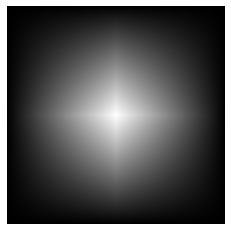

In [3]:
w, h = image.shape
l, c = divmod(numpy.arange(math.prod(image.shape)).reshape(image.shape), w)

l = l.astype(numpy.float64)
lb = l * (l <= w/2)
lb *= 1 / numpy.max(lb)
la = l * (l > w/2)
la = numpy.max(la) - la
la *= (l > w/2)
la -= numpy.min(la)
la *= (l > w/2)
la /= numpy.max(la)

c = c.astype(numpy.float64)
cb = c * (c <= w/2)
cb *= 1 / numpy.max(cb)
ca = c * (c > w/2)
ca = numpy.max(ca) - ca
ca *= (c > w/2)
ca -= numpy.min(ca)
ca *= (c > w/2)
ca /= numpy.max(ca)

mask = (lb + la) * (cb + ca)
pyplot.axis('off')
pyplot.imshow(mask, cmap=pyplot.cm.gray)

Iremos aplicar a máscara na imagem

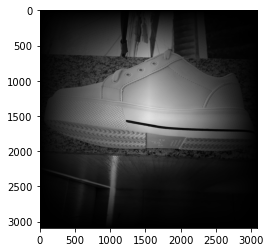

In [4]:
imageWithMask = image * mask
pyplot.imshow(imageWithMask, cmap=pyplot.cm.gray)

Iremos aplicar o método de limiarização de Otsu

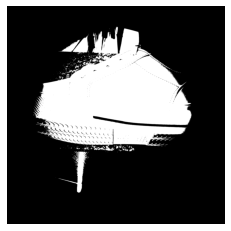

In [5]:
thresh = filters.threshold_otsu(imageWithMask)
binary = imageWithMask > thresh
pyplot.axis('off')
pyplot.imshow(binary, cmap=pyplot.cm.gray)

Iremos inverter as cores, pois skimage entende que em branco é a imagem e preto é o fundo

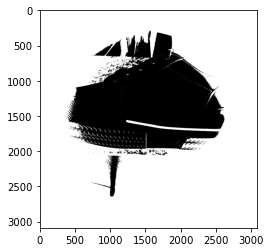

In [6]:
binary_inverted = numpy.invert(binary)
pyplot.imshow(binary_inverted, cmap=pyplot.cm.gray)

Aplicaremos novamente a máscara e aplicaremos o filtro passa alta, para remover o fundo completamente

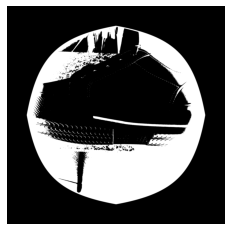

In [7]:
binary_inverted = binary_inverted * mask
thresh = filters.threshold_otsu(binary_inverted)
binary_inverted = binary_inverted > thresh
pyplot.axis('off')
pyplot.imshow(binary_inverted, cmap=pyplot.cm.gray)

Para deixar a função mais genérica iremos assumir que o fundo sempre será a maior parte da imagem.

Assumiremos também que o objeto é branco e o fundo é preto.

Assim iremos sempre usar a imagem cuja média tem o menor valor.

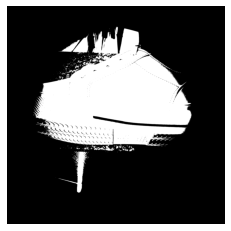

In [8]:
mean_binary = numpy.mean(binary)
mean_binary_inverted = numpy.mean(binary_inverted)
if mean_binary > mean_binary_inverted:
    binary = binary_inverted
pyplot.axis('off')
pyplot.imshow(binary, cmap=pyplot.cm.gray)

Iremos aplicar a operação morfológica de erosão para remover possíveis ruídos e depois reconstruir a partir da imagem de saída

In [ ]:
binary_erosion = morphology.erosion(binary, morphology.disk(25))
binary = morphology.reconstruction(binary_erosion, binary)
pyplot.axis('off')
pyplot.imshow(binary, cmap=pyplot.cm.gray)

Iremos compilar tudo em uma única função, mas com um detalhe comentado no código abaixo

In [ ]:
def segmentacao(image_ndarray):
    w, h = image_ndarray.shape
    l, c = divmod(numpy.arange(math.prod(image_ndarray.shape)).reshape(image_ndarray.shape), w)

    l = l.astype(numpy.float64)
    lb = l * (l <= w/2)
    lb *= 1 / numpy.max(lb)
    la = l * (l > w/2)
    la = numpy.max(la) - la
    la *= (l > w/2)
    la -= numpy.min(la)
    la *= (l > w/2)
    la /= numpy.max(la)

    c = c.astype(numpy.float64)
    cb = c * (c <= w/2)
    cb *= 1 / numpy.max(cb)
    ca = c * (c > w/2)
    ca = numpy.max(ca) - ca
    ca *= (c > w/2)
    ca -= numpy.min(ca)
    ca *= (c > w/2)
    ca /= numpy.max(ca)

    mask = (lb + la) * (cb + ca)
    
    imageWithMask = image_ndarray * mask
    
    thresh = filters.threshold_otsu(imageWithMask)
    binary = imageWithMask > thresh
    
    binary_inverted = numpy.invert(binary)
    
    binary_inverted = binary_inverted * mask
    thresh = filters.threshold_otsu(binary_inverted)
    binary_inverted = binary_inverted > thresh
    
    mean_binary = numpy.mean(binary)
    mean_binary_inverted = numpy.mean(binary_inverted)
    if mean_binary > mean_binary_inverted:
        binary = binary_inverted
    
    binary_erosion = morphology.erosion(binary, morphology.disk(25))
    binary = morphology.reconstruction(binary_erosion, binary)
    return binary

Iremos testar a função de segmetação para alguma imagens

In [ ]:
image_path = pathlib.Path(r"originalGrayDataset\BATOM\DIA\DENTRO\BRANCO\IMG_20210501_143727.jpg")
image = io.imread(image_path)
pyplot.subplot(1,2,1)
pyplot.axis('off')
pyplot.imshow(image, cmap=pyplot.cm.gray)
pyplot.subplot(1,2,2)
pyplot.axis('off')
pyplot.imshow(segmentacao(image), cmap=pyplot.cm.gray)

Vamos aplicar a função de segmentação para outra imagem

In [ ]:
image_path = pathlib.Path(r"originalGrayDataset\TENIS\DIA\DENTRO\GRANITO\20210424_114639.jpg")
image = io.imread(image_path)
pyplot.subplot(1,2,1)
pyplot.axis('off')
pyplot.imshow(image, cmap=pyplot.cm.gray)
pyplot.subplot(1,2,2)
pyplot.axis('off')
pyplot.imshow(segmentacao(image), cmap=pyplot.cm.gray)

Agora aplicaremos para todo originalGrayDataset

In [ ]:
original_gray_dataset_path = pathlib.Path('originalGrayDataset')
path_list = list(original_gray_dataset_path.glob('**/*.jpg'))
n_col = 5
n_lin = math.ceil(len(path_list) / n_col)
fig, ax = pyplot.subplots(n_lin, n_col)
for index, path in enumerate(path_list):
    image = io.imread(path)
    image_path = pathlib.Path(str(path).replace('originalGrayDataset', 'autoSegmentation'))
    if not image_path.exists():
        image_path.parent.mkdir(parents=True, exist_ok=True)
        io.imsave(image_path, segmentacao(image))